In [1]:
from collections import defaultdict
from datetime import datetime
import math
from operator import itemgetter
import os
import random
import re
import sqlite3

import numpy as np
import pandas as pd

%matplotlib inline

import little_mallet_wrapper as lmw

In [2]:
path_to_mallet = '/Users/thaochu/mallet-2.0.8/bin/mallet'

In [11]:
# create database in DB browser for SQLite
conn = sqlite3.connect("deidatastore.db")
c = conn.cursor()

df_text = pd.read_sql(f"""select s.unitid
, unitid_i
, title
, p_text
, p_word_count 
, type
from scrape s

left  join 
(select 
DISTINCT(unitid) as unitid_usnews
, type
from usnews) u

on u.unitid_usnews = s.unitid""", conn)

In [12]:
df_text = df_text.drop_duplicates(subset='p_text')
df_text = df_text.replace(to_replace='None', value=np.nan).dropna().reset_index()

In [6]:
df_text.nunique()

index           391
unitid          264
unitid_i        391
title           235
p_text          391
p_word_count    323
type              2
dtype: int64

In [14]:
# create custom list of college names to remove as stop words
inst_df = pd.read_sql(f"""
select 
DISTINCT(u.unitid)
, instnm

from  usnews u
left join scorecard s on u.unitid = s.unitid""", conn)

all_college = " ".join(inst_df['instnm'].dropna()).lower()  # lowercase 
college_names = re.findall(r'\b\w+\b', all_college)  # Extract words only, ignoring punctuation

# Get unique words
college_names = list(set(college_names))

### Training data

In [17]:
training_data = [lmw.process_string(t, numbers='remove', stop_words = college_names) for t in df_text['p_text'].tolist()]
training_data = [d for d in training_data if d.strip()]

len(training_data)

391

In [21]:
training_data[2]

'together strive create environment that values diversity promotes inclusive culture establishes profound sense belonging for each member our community loretta lynch invoked words calling audience reclaim his legacy face reversal decades progress sherri charleston chief diversity inclusion officer alan garber president office for equity diversity inclusion belonging works with stakeholders partners across guide culture toward inclusive excellence subscribe newsletter for latest news events learn about office disability resources provides leadership efforts ensure accessible inclusive welcoming learning working environment for individuals with disabilities while complying with federal regulations learn about resources explore ways that turning goals ideas into actions results need support explore our resources all community members have access wide array resources across ongoing events for students staff faculty our local global community culture lab grants programs initiatives encourag

In [22]:
# liberal arts vs research
types = df_text['type'].tolist()

len(types)

391

In [23]:
lmw.print_dataset_stats(training_data)

Number of Documents: 391
Mean Number of Words per Document: 321.4
Vocabulary Size: 12005


### Training data into directory

In [27]:
output_directory_path = '/Users/thaochu/senior-research-git/DEI-Statements-Analysis/lmw-output'

In [29]:
# Folder to save the text files
output_folder = "dei_sample"
os.makedirs(os.path.join(output_directory_path, output_folder), exist_ok=True)

file_name_column = 'unitid_i'
content_column = 'p_text'

# Loop through DataFrame and create text files
for e, row in df_text.iterrows():
    file_name = row[file_name_column]
    content = row[content_column]

    file_path = os.path.join(output_directory_path, output_folder, f"{file_name}.txt")
    
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(content)

print(f"Text files have been saved in the folder: {output_folder}")

Text files have been saved in the folder: dei_sample


# Train topic model

In [30]:
# Import data for training

num_topics = 40

path_to_training_data           = output_directory_path + '/dei_sample/*'
path_to_formatted_training_data = output_directory_path + '/mallet.training'
path_to_model                   = output_directory_path + '/mallet.model.' + str(num_topics)
path_to_topic_keys              = output_directory_path + '/mallet.topic_keys.' + str(num_topics)
path_to_topic_distributions     = output_directory_path + '/mallet.topic_distributions.' + str(num_topics)
path_to_word_weights            = output_directory_path + '/mallet.word_weights.' + str(num_topics)
path_to_diagnostics             = output_directory_path + '/mallet.diagnostics.' + str(num_topics) + '.xml'

In [31]:
lmw.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                training_data)

Importing data...
Complete


In [32]:
lmw.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      path_to_word_weights,
                      path_to_diagnostics,
                      num_topics)

Training topic model...


Mallet LDA: 40 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 4421
total tokens: 125674
<10> LL/token: -9.24019
<20> LL/token: -8.90061
<30> LL/token: -8.76897
<40> LL/token: -8.68096

0	0.125	edu email this site phone please programs nyu from their office not its that person opportunities avenue contact available quality 
1	0.125	was from has years two been business not degree leadership have which food philadelphia rights when nation after where master 
2	0.125	you about learn your resources mcla out get leadership through organization involved others equity explore with admission connect promote street 
3	0.125	faculty for that learn explore resources about inclusive leadership world learning diverse staff engagement culture wide scholarship people initiatives can 
4	0.125	with about program racism black access research their services people through here communities online programs between indigenous they other only 
5	0.125	our program for work first who one have 

Complete


[beta: 0.01813] 
<420> LL/token: -8.19342
[beta: 0.0182] 
<430> LL/token: -8.19173
[beta: 0.01825] 
<440> LL/token: -8.18241

0	0.01886	NUMpm colgate NUMam NUMis pst/NUMpm est also autism davies phd professor health lvc asd said served hospital years urology certificate 
1	0.11519	university catholic commitment faith higher goucher strong thomas teaching john institution human integrity state discrimination antioch jesuit form search climate 
2	0.43753	NUM university edu research october community health events world rights news director global equity gallaudet hall explore access march oct 
3	0.03333	NUM denver msu hbcu schedule ohio university scholars succeed admission tomorrow close prepare hallNUM apply main oregoneugene avisit requestinfo portsmouth 
4	0.05151	back chatham women calendar sage duke russell october salem see centre link odi register illinois join main pittsburgh bio details 
5	0.06625	award university diversity heed gonzaga year education higher said commitment ins

[beta: 0.0186] 
<510> LL/token: -8.17222
[beta: 0.01852] 
<520> LL/token: -8.16359
[beta: 0.01845] 
<530> LL/token: -8.16359
[beta: 0.01864] 
<540> LL/token: -8.16185

0	0.01736	NUMpm colgate NUMam NUMis pst/NUMpm new est autism also health davies phd first lvc asd certificate served hospital said professor 
1	0.06419	university catholic education higher goucher thomas search member state antioch francis jesuit teaching creighton calendar discrimination sfc faith colorado human 
2	0.45279	NUM university edu equity research october health access email hall events rights news director gallaudet related schools world march NUMth 
3	0.03249	denver msu ohio hbcu schedule university succeed prepare apply admission excellence scholars street hallNUM tomorrow main oregoneugene avisit requestinfo portsmouth 
4	0.0237	back chatham women sage russell duke odi salem calendar centre see main pittsburgh bio link chancellor queer forest register join 
5	0.06672	award university diversity heed gonzaga

[beta: 0.01879] 
<600> LL/token: -8.15767
[beta: 0.01859] 
<610> LL/token: -8.14663
[beta: 0.01881] 
<620> LL/token: -8.15894
[beta: 0.01882] 
<630> LL/token: -8.15725
[beta: 0.01887] 
<640> LL/token: -8.15407

0	0.0164	NUMpm colgate NUMam NUMis pst/NUMpm est also autism davies certificate served phd said lvc asd board hospital urology health weiss 
1	0.05418	university catholic goucher thomas higher jesuit education antioch creighton career beyond search francis colorado state professional discrimination sfc faith franciscan 
2	0.46292	NUM university edu health october research equity world events news director schools series NUMth gallaudet march email hall programs global 
3	0.03651	university denver msu ohio hbcu succeed virginia admission prepare apply main schedule tomorrow oregoneugene hallNUM avisit requestinfo portsmouth excellence shawnee 
4	0.02892	back chatham women sage russell duke salem centre odi calendar chancellor main see pittsburgh pitt bio register illinois link es

[beta: 0.01917] 
<720> LL/token: -8.15106
[beta: 0.01912] 
<730> LL/token: -8.15169
[beta: 0.01906] 
<740> LL/token: -8.15084

0	0.01494	NUMpm colgate NUMam NUMis pst/NUMpm est autism davies first phd years lvc asd board hospital urology certificate weiss assistant said 
1	0.0346	university catholic goucher higher thomas state antioch education creighton francis search human sfc colorado franciscan coastal form faith responsibility safe 
2	0.46654	NUM university edu october research health email NUMth events rights equity news world access gallaudet global hall march schools made 
3	0.03753	ohio hbcu admission virginia schedule succeed mission university apply excellence close scholars prepare hallNUM shawnee tomorrow main oregoneugene avisit requestinfo 
4	0.02287	back chatham sage women russell duke illinois odi calendar centre salem register main pittsburgh bio chancellor queer forest details link 
5	0.06819	university award diversity heed higher gonzaga indiana year said insight pr

[beta: 0.01926] 
<810> LL/token: -8.14715
[beta: 0.01916] 
<820> LL/token: -8.14
[beta: 0.01916] 
<830> LL/token: -8.14582
[beta: 0.01921] 
<840> LL/token: -8.14572

0	0.01398	NUMpm colgate NUMam NUMis pst/NUMpm est professor autism davies phd certificate lvc asd hospital board first urology years weiss residential 
1	0.03831	university catholic goucher thomas state antioch francis respect creighton higher growth beyond search sfc faith franciscan coastal carolina form responsibility 
2	0.45858	NUM university equity edu research october health email NUMth excellence access news director contact world global gallaudet available march schools 
3	0.03431	university ohio hbcu succeed apply main hallNUM cincinnati tomorrow schedule prepare oregoneugene avisit requestinfo portsmouth close scholars today admission mission 
4	0.02703	back chatham women sage russell duke illinois odi centre salem link pittsburgh register calendar queer society bio estudiantes pitt details 
5	0.06167	university 

[beta: 0.01932] 
<900> LL/token: -8.14378
[beta: 0.01943] 
<910> LL/token: -8.14468
[beta: 0.01925] 
<920> LL/token: -8.14397
[beta: 0.01936] 
<930> LL/token: -8.14306
[beta: 0.0195] 
<940> LL/token: -8.14731

0	0.01237	NUMpm colgate NUMam NUMis new pst/NUMpm est autism professor davies phd lvc asd hospital urology first weiss certificate assistant residential 
1	0.0419	university catholic goucher thomas state higher development antioch francis creighton education sfc responsibility franciscan coastal colorado human carolina searches beyond 
2	0.50008	NUM university edu research october equity health email director world NUMth hall march phone news events innovation please global november 
3	0.02777	ohio hbcu prepare today schedule main succeed close hallNUM cincinnati tomorrow apply admission mission oregoneugene avisit requestinfo portsmouth street shawnee 
4	0.02912	back chatham sage duke russell illinois women salem odi centre join main pittsburgh bio details register link retreat 

Complete


In [33]:
topic_keys = lmw.load_topic_keys(output_directory_path + '/mallet.topic_keys.' + str(num_topics))

for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:10]))

0 	 nyu faculty world global innovation their range understanding around join
1 	 for has was professor research president her director also been
2 	 mcla street hbcu second you succeed prepare floor world tomorrow
3 	 faculty research programs staff resources dei leadership develop slavery teaching
4 	 racism racial anti race indigenous higher home alumni tcu racist
5 	 use stem cookies consortium sfc synchrony underserved fellowships under increasing
6 	 women lgbtq center gender history black african celebration queer awareness
7 	 gender status identity race orientation sexual religion age national disability
8 	 cookies website cookie that our site you your set google
9 	 students program their year scholars first academic years graduate through
10 	 with for that this from will their who education which
11 	 equity plan work this belonging opportunity action initiatives strategic access
12 	 for business lmu odi his estudiantes justice para hosted mireles
13 	 community our all t

In [34]:
topic_distributions = lmw.load_topic_distributions(output_directory_path + '/mallet.topic_distributions.' + str(num_topics))

len(topic_distributions), len(topic_distributions[0])

(391, 40)

In [35]:
assert(len(topic_distributions) == len(training_data))

In [57]:
for p, d in lmw.get_top_docs(training_data, topic_distributions, topic_index=39, n=3):
    print(round(p, 4), d)
    print()

0.426 link link list resources below intended provide information for mcla community members who want learn about issues systemic racism privilege anti racism work this small sampling resources available many are available through mcla freel library white fragility why hard for white people talk about racismby robin diangelo phd black feminist thoughtby patricia eloquent rage black feminist discovers her superpowerby brittney cooper heavy memoirby kiese laymon how antiracistby ibram kendi know why caged bird singsby maya angelou just mercyby bryan stevenson white supremacyby layla saad raising our handsby jenna arnold redefining realnessby janet mock sister outsiderby audre lorde you want talk about raceby ijeoma oluo bluest eyeby toni morrison fire next timeby james baldwin jim crow mass incarceration age colorblindnessby michelle alexander next revolution sustainable activism for twenty first centuryby grace boggs warmth other sunsby isabel wilkerson their eyes were watching godby zo

In [38]:
topic_word_probability_dict = lmw.load_topic_word_distributions(output_directory_path + '/mallet.word_weights.' + str(num_topics))

len(topic_word_probability_dict)

40

In [45]:
# for each topic, get top 15 words with the highest probabilities of that topic
for _topic, _word_probability_dict in topic_word_probability_dict.items():
    print('Topic', _topic)
    for _word, _probability in sorted(_word_probability_dict.items(), key=lambda x: x[1], reverse=True)[:15]:
        print(round(_probability, 4), '\t', _word)
    print()

Topic 0
0.0279 	 nyu
0.0263 	 world
0.0263 	 faculty
0.0192 	 global
0.0152 	 innovation
0.0144 	 their
0.0128 	 range
0.012 	 around
0.012 	 understanding
0.0112 	 institution
0.0112 	 diverse
0.0112 	 join
0.0104 	 opportunities
0.0096 	 challenges
0.0096 	 scholars

Topic 1
0.0398 	 for
0.0331 	 has
0.0289 	 was
0.0182 	 research
0.0182 	 professor
0.0174 	 president
0.0169 	 director
0.0169 	 her
0.0129 	 also
0.0124 	 been
0.0122 	 public
0.0109 	 she
0.0107 	 two
0.0105 	 national
0.0105 	 associate

Topic 2
0.0418 	 mcla
0.0194 	 street
0.0175 	 hbcu
0.0156 	 second
0.0136 	 you
0.0126 	 prepare
0.0126 	 succeed
0.0117 	 world
0.0117 	 floor
0.0107 	 equity
0.0107 	 apply
0.0107 	 close
0.0107 	 tomorrow
0.0097 	 portsmouth
0.0097 	 requestinfo

Topic 3
0.0205 	 faculty
0.0194 	 research
0.0146 	 programs
0.014 	 staff
0.0113 	 resources
0.0108 	 leadership
0.0108 	 dei
0.0103 	 develop
0.0092 	 teaching
0.0092 	 slavery
0.0086 	 scholarship
0.0086 	 justice
0.0086 	 wide
0.0086

In [51]:
# Creating table for topic - words 
data = []

# Extract topic and words, ordered by probability
for _topic, _word_probability_dict in topic_word_probability_dict.items():
    # Get the sorted list of words for the topic
    sorted_words = [word for word, prob in sorted(_word_probability_dict.items(), key=lambda x: x[1], reverse=True)]
    # Add to the data list
    data.append({'Topic': _topic, 'Words': ', '.join(sorted_words[:20])}) 

# Create a DataFrame
df = pd.DataFrame(data)

from IPython.display import display
display(df)


,Topic,Words
0,0,"nyu, world, faculty, global, innovation, their..."
1,1,"for, has, was, research, professor, president,..."
2,2,"mcla, street, hbcu, second, you, prepare, succ..."
3,3,"faculty, research, programs, staff, resources,..."
4,4,"racism, anti, racial, race, higher, indigenous..."
5,5,"use, cookies, stem, consortium, under, fellows..."
6,6,"women, center, lgbtq, gender, history, black, ..."
7,7,"gender, status, identity, race, orientation, s..."
8,8,"cookies, website, cookie, that, our, site, you..."
9,9,"students, program, their, year, scholars, firs..."


In [52]:
df.to_csv('topics_top_words.csv', index=False)

In [41]:
lmw.get_js_divergence_topics(0, 7, topic_word_probability_dict)

0.7682934412041205

# Plot

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


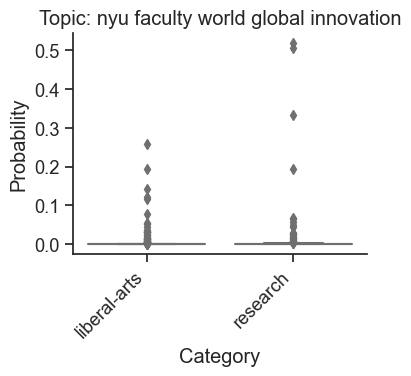

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


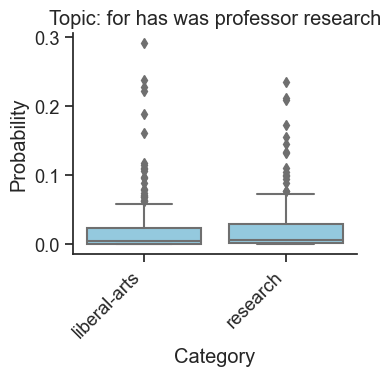

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


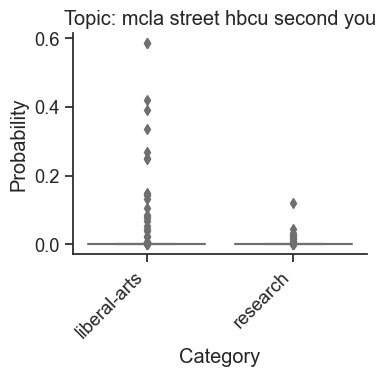

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


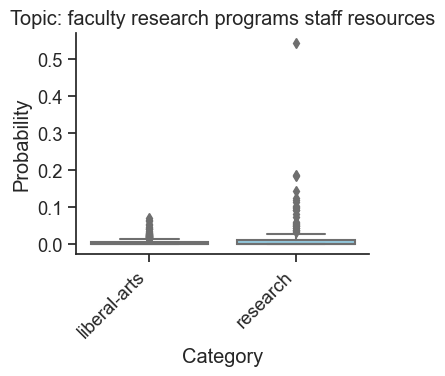

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


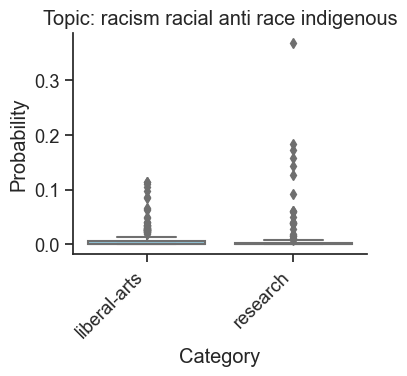

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


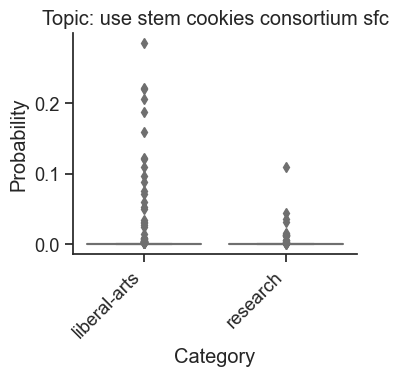

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


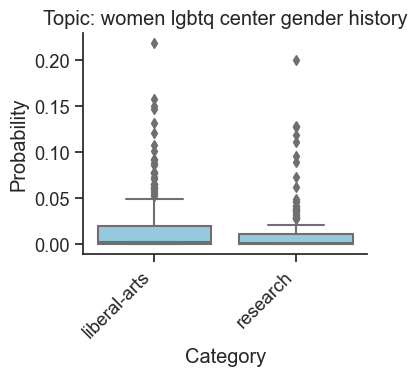

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


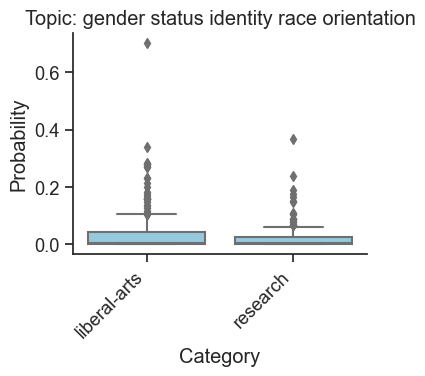

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


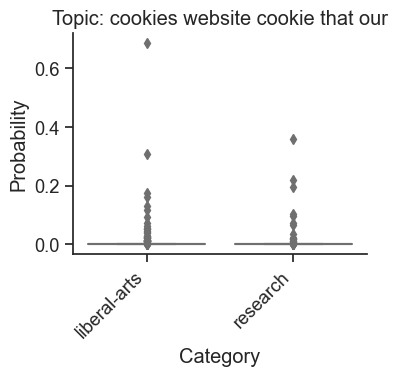

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


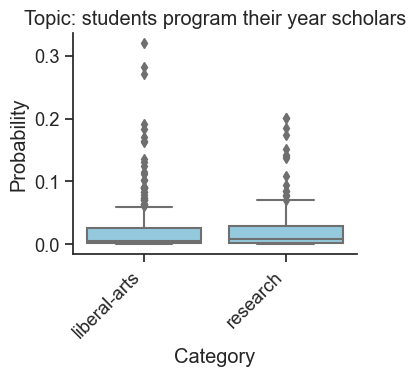

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


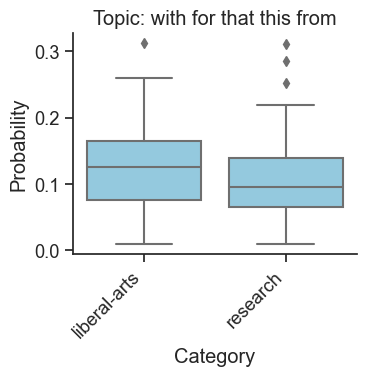

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


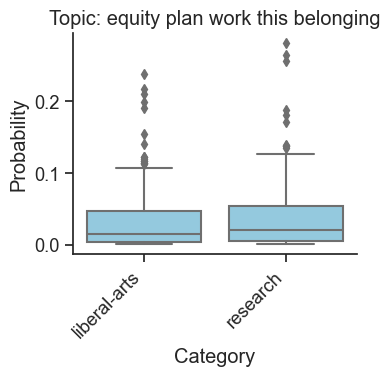

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


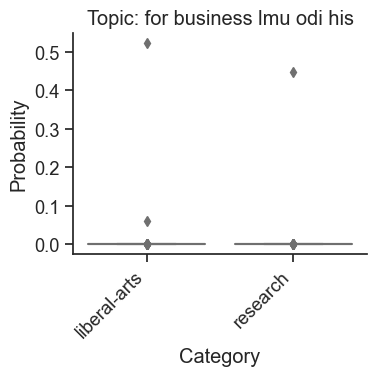

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


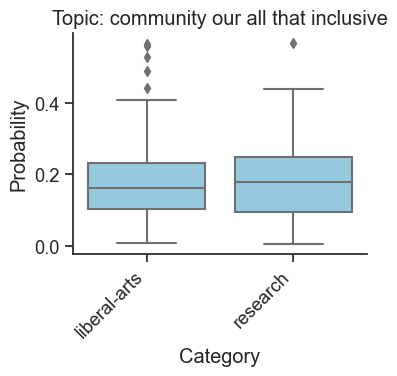

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


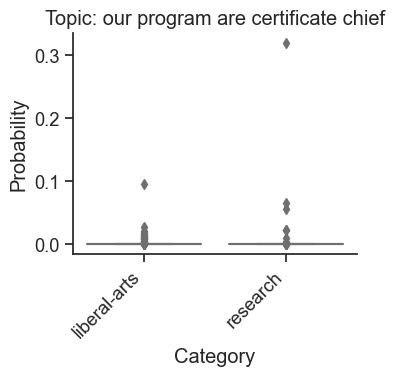

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


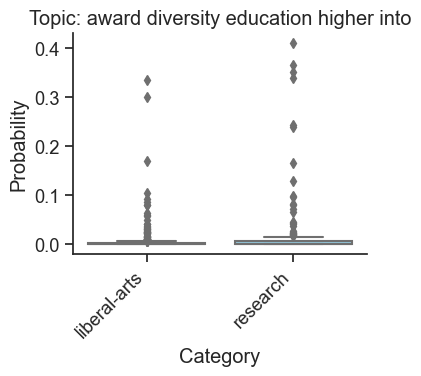

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


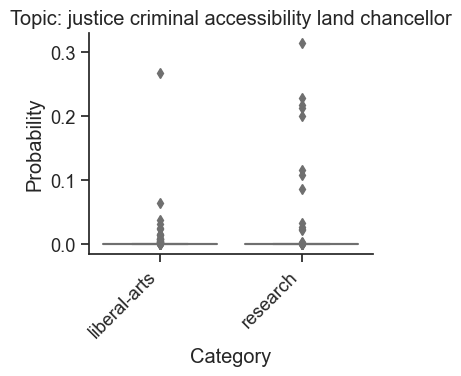

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


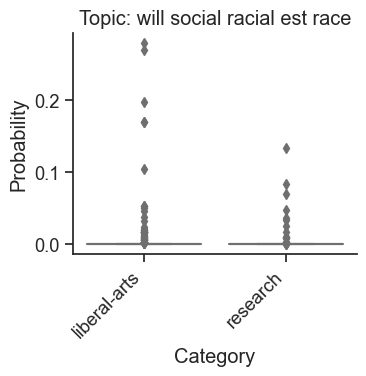

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


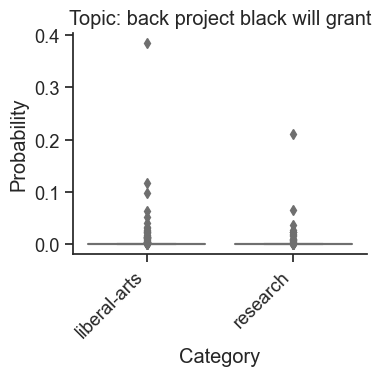

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


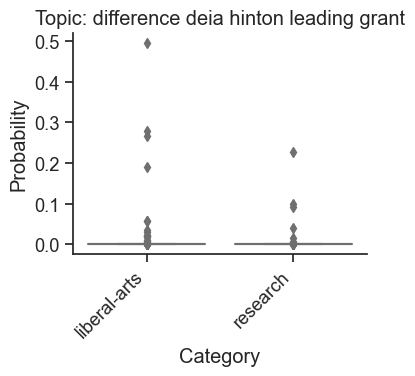

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


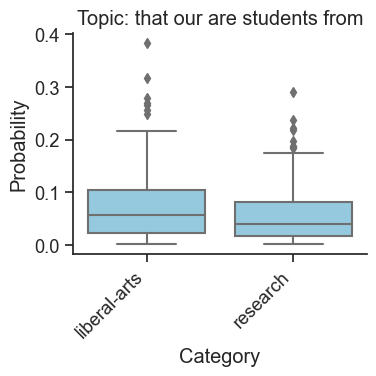

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


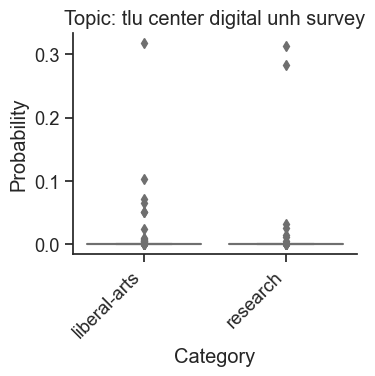

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


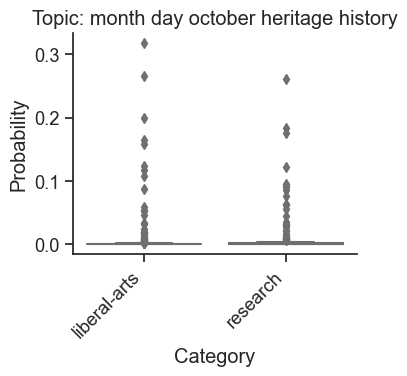

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


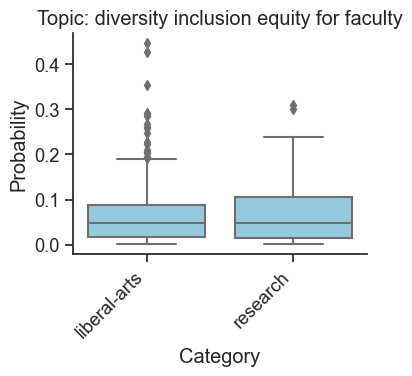

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


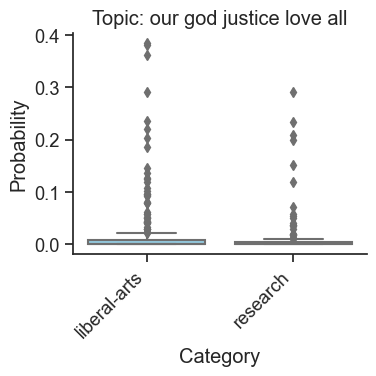

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


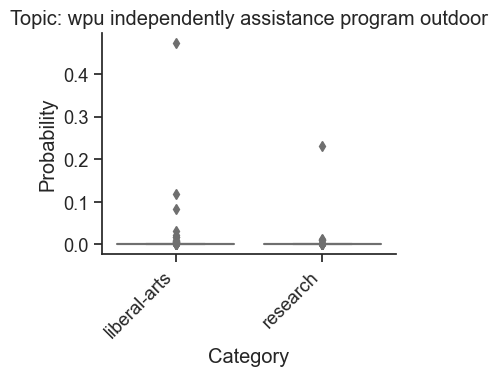

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


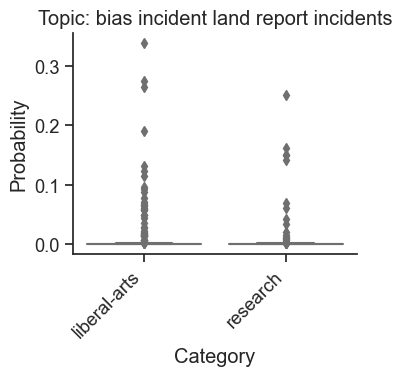

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


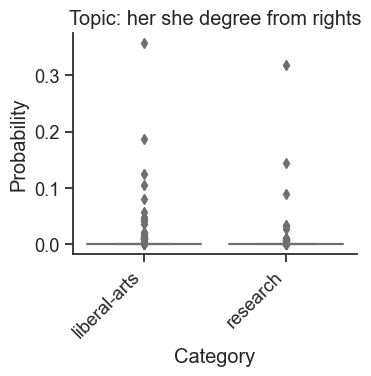

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


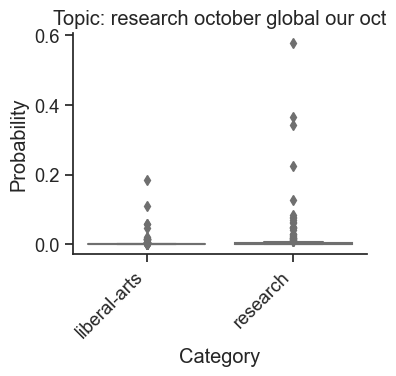

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


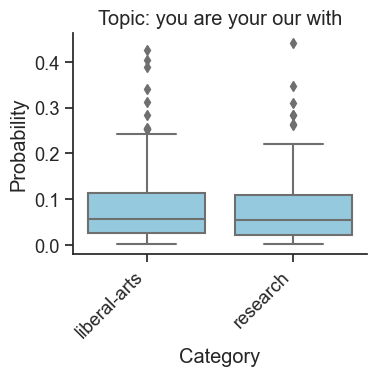

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


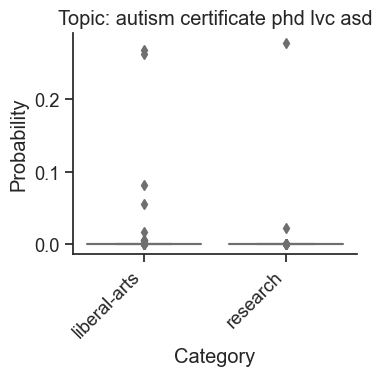

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


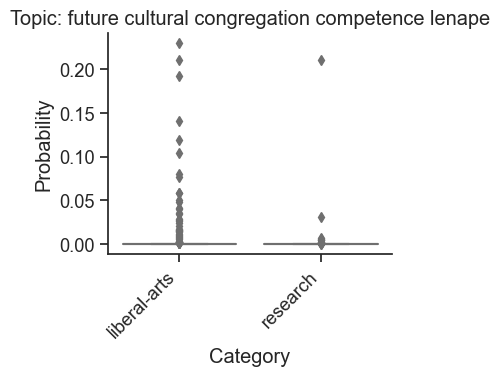

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


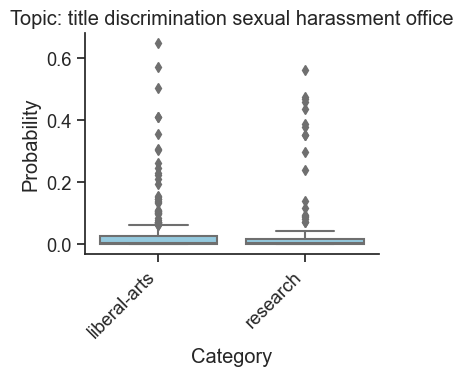

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


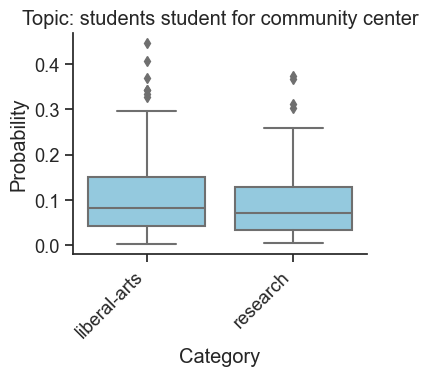

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


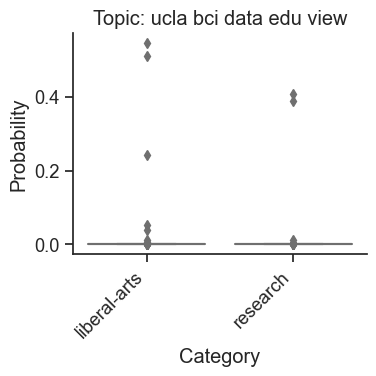

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


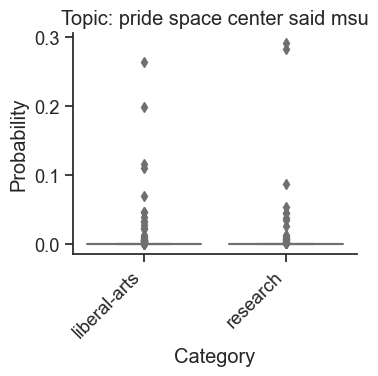

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


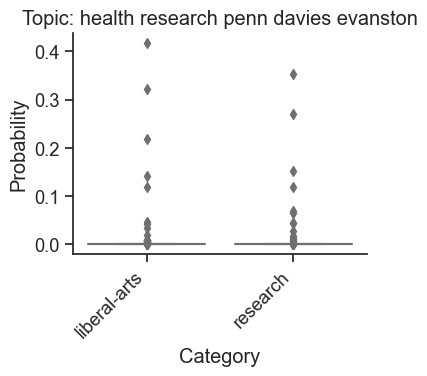

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


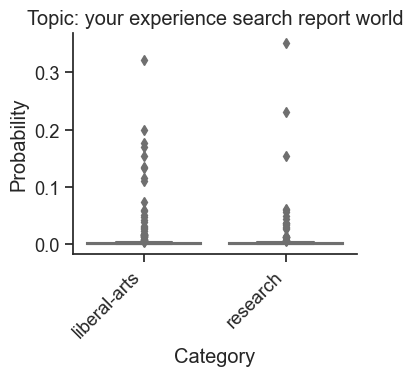

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


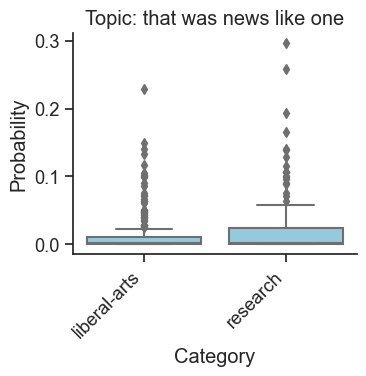

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


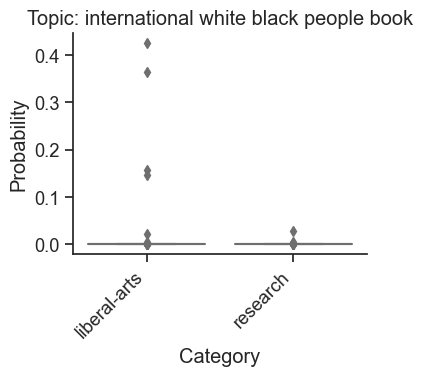

In [58]:
target_labels = ['liberal-arts', 'research']

for _topic_index in range(0, len(topic_keys)):
    
    lmw.plot_categories_by_topic_boxplots(types,
                                          topic_distributions,
                                          topic_keys, 
                                          _topic_index,
                                          output_path=output_directory_path + '/boxplot.' + str(_topic_index) + '.pdf',
                                          target_labels=target_labels,
                                          dim=(4,4))